In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette('bright')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')
from scipy import fft

(-2.0, 2.0)

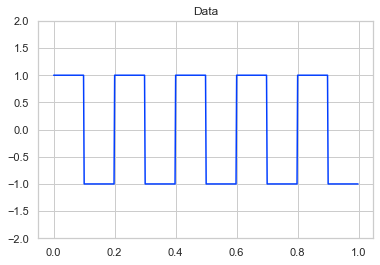

In [151]:
from scipy import signal
x = np.linspace(0, 1, 500, endpoint=False)
y = signal.square(2 * np.pi * 5 * x)
plt.title('Data')
plt.plot(x,y)
plt.ylim(-2, 2)

In [152]:
signal_3 = pd.DataFrame(zip(x,y),columns=['Time','Value'])

# GMM on actual time series

In [153]:
dfx = signal_3
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [154]:
print(best_gmm, '\n')
print('WEIGHTS -', best_gmm.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=6) 

WEIGHTS - [0.19859844 0.09533517 0.19851259 0.17145724 0.20615224 0.12994432] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 0.25217248 -1.        ]
 [ 0.04795611  1.        ]
 [ 0.74511503  1.        ]
 [ 0.86705225 -1.        ]
 [ 0.34932137  1.        ]
 [ 0.58299242 -1.        ]] 



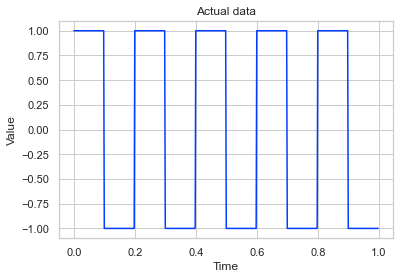

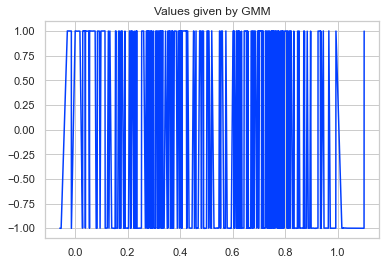

In [155]:
z,_ = best_gmm.sample(500)
plt.title('Actual data')
sns.lineplot(signal_3['Time'], signal_3['Value'])
plt.show()
plt.title('Values given by GMM')
sns.lineplot(z[:,0],z[:,1])
plt.show()

# GMM on FFT of actual time series

In [156]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    freq_ampli_real = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].real),columns=['Freq','Ampli'])
    freq_ampli_img = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].imag),columns=['Freq','Ampli'])
    return freq_ampli_real,freq_ampli_img
freq_ampli3,freq_ampli3i = freq(signal_3)

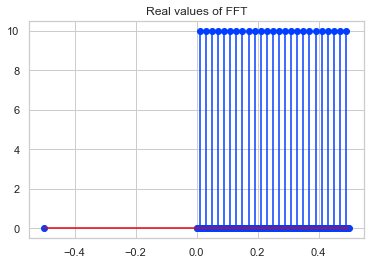

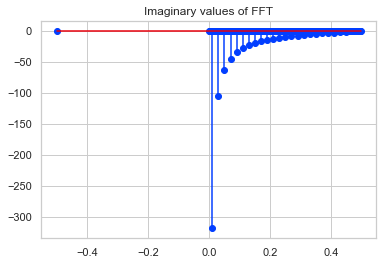

In [157]:
plt.stem(freq_ampli3['Freq'], freq_ampli3['Ampli'])
plt.title('Real values of FFT')
plt.show()
plt.stem(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.title('Imaginary values of FFT')
plt.show()

In [158]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 7)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [159]:
best_gmm0 = GMM_fit(freq_ampli3)                        # GMM on real part of FFT data
best_gmm0i = GMM_fit(freq_ampli3i)                      # GMM on imaginary part of FFT data

In [160]:
print(best_gmm0, '\n')
print('WEIGHTS -', best_gmm0.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0.means_, '\n')

GaussianMixture(covariance_type='tied', n_components=2) 

WEIGHTS - [0.90039841 0.09960159] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 2.45575221e-01 -1.72919692e-16]
 [ 2.50000000e-01  1.00000000e+01]] 



In [161]:
print(best_gmm0i, '\n')
print('WEIGHTS -', best_gmm0i.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0i.means_, '\n')

GaussianMixture(n_components=6) 

WEIGHTS - [0.90038934 0.00398406 0.00398406 0.01195434 0.00398406 0.07570413] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 2.45573151e-01  5.64935965e-17]
 [ 1.00000000e-02 -3.18205160e+02]
 [ 5.00000000e-02 -6.31375151e+01]
 [ 9.00072157e-02 -3.56423141e+01]
 [ 3.00000000e-02 -1.05788950e+02]
 [ 3.10022022e-01 -8.36083254e+00]] 



In [162]:
#Sampling
z1,_ = best_gmm0.sample(251)
z1i,_ = best_gmm0i.sample(251)

In [163]:
sample_1 = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])           
sample_1i = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])

In [164]:
sample_1 = sample_1.sort_values(by=['Freq'],ascending=True)     
sample_1 = sample_1[sample_1.Freq > 0]                           
sample_1i = sample_1i.sort_values(by=['Freq'],ascending=True)
sample_1i = sample_1i[sample_1i.Freq > 0]                        

In [165]:
sample_1 = sample_1[(sample_1.Ampli>1) | (sample_1.Ampli<-1)]
sample_1i = sample_1i[(sample_1i.Ampli>1) | (sample_1i.Ampli<-1)]

In [166]:
f = fftpack.fftfreq(500)                                    # The frequency corresponding to each value in FFT is stored in 'f'

In [167]:
sd = dict(zip(np.round(f,3),np.zeros(len(f))))

In [168]:
sample_1.Freq = sample_1.Freq.apply(lambda x:round(x,3))       
sample_1i.Freq = sample_1i.Freq.apply(lambda x:round(x,3))

In [169]:
samp_1 = dict(zip(sample_1.Freq,sample_1.Ampli))
samp_1i = dict(zip(sample_1i.Freq,sample_1i.Ampli))

In [170]:
for i in samp_1.keys():
    if i in sd:
        sd[i] = samp_1[i]
        sd[-i] = samp_1[i]
    elif i+0.001 in sd:
        sd[i+0.001] = samp_1[i]
        sd[-(i+0.001)] = samp_1[i]
    elif i-0.001 in sd:
        sd[i-0.001] = samp_1[i]
        sd[-(i-0.001)] = samp_1[i]
sd

{0.0: 0.0,
 0.002: 0.0,
 0.004: 0.0,
 0.006: 0.0,
 0.008: 0.0,
 0.01: 0.0,
 0.012: 0.0,
 0.014: 0.0,
 0.016: 0.0,
 0.018: 0.0,
 0.02: 0.0,
 0.022: 0.0,
 0.024: 0.0,
 0.026: 0.0,
 0.028: 0.0,
 0.03: 0.0,
 0.032: 0.0,
 0.034: 0.0,
 0.036: 0.0,
 0.038: 0.0,
 0.04: 0.0,
 0.042: 0.0,
 0.044: 0.0,
 0.046: 0.0,
 0.048: 0.0,
 0.05: 0.0,
 0.052: 0.0,
 0.054: 0.0,
 0.056: 0.0,
 0.058: 0.0,
 0.06: 0.0,
 0.062: 0.0,
 0.064: 0.0,
 0.066: 0.0,
 0.068: 0.0,
 0.07: 0.0,
 0.072: 0.0,
 0.074: 0.0,
 0.076: 0.0,
 0.078: 0.0,
 0.08: 0.0,
 0.082: 0.0,
 0.084: 0.0,
 0.086: 0.0,
 0.088: 0.0,
 0.09: 0.0,
 0.092: 10.000228130998009,
 0.094: 0.0,
 0.096: 0.0,
 0.098: 0.0,
 0.1: 0.0,
 0.102: 0.0,
 0.104: 0.0,
 0.106: 0.0,
 0.108: 0.0,
 0.11: 0.0,
 0.112: 0.0,
 0.114: 0.0,
 0.116: 0.0,
 0.118: 0.0,
 0.12: 0.0,
 0.122: 9.999959385150289,
 0.124: 0.0,
 0.126: 0.0,
 0.128: 10.000823146456076,
 0.13: 0.0,
 0.132: 0.0,
 0.134: 0.0,
 0.136: 0.0,
 0.138: 0.0,
 0.14: 0.0,
 0.142: 0.0,
 0.144: 0.0,
 0.146: 0.0,
 0.148: 0.0

In [171]:
for i in samp_1i.keys():
    if i in sd:
        sd[i] = complex(sd[i],samp_1i[i])
        sd[-i] = complex(sd[i],-(samp_1i[i]))
    elif i+0.001 in sd:
        sd[i+0.001] = complex(sd[i+0.001],samp_1i[i])
        sd[-(i+0.001)] = complex(sd[i+0.001],-(samp_1i[i]))
    elif i-0.001 in sd:
        sd[i-0.001] = complex(sd[i-0.001],samp_1i[i])
        sd[-(i-0.001)] = complex(sd[i-0.001],-(samp_1i[i]))
sd

{0.0: 0.0,
 0.002: 0.0,
 0.004: 0.0,
 0.006: 0.0,
 0.008: 0.0,
 0.01: -318.2031044958545j,
 0.012: 0.0,
 0.014: 0.0,
 0.016: 0.0,
 0.018: 0.0,
 0.02: 0.0,
 0.022: 0.0,
 0.024: 0.0,
 0.026: 0.0,
 0.028: 0.0,
 0.03: 0.0,
 0.032: -105.78956266195111j,
 0.034: 0.0,
 0.036: 0.0,
 0.038: 0.0,
 0.04: 0.0,
 0.042: 0.0,
 0.044: 0.0,
 0.046: 0.0,
 0.048: 0.0,
 0.05: -63.137637449402j,
 0.052: 0.0,
 0.054: 0.0,
 0.056: 0.0,
 0.058: 0.0,
 0.06: 0.0,
 0.062: 0.0,
 0.064: 0.0,
 0.066: 0.0,
 0.068: 0.0,
 0.07: 0.0,
 0.072: 0.0,
 0.074: 0.0,
 0.076: 0.0,
 0.078: 0.0,
 0.08: 0.0,
 0.082: 0.0,
 0.084: -37.97798109480039j,
 0.086: 0.0,
 0.088: 0.0,
 0.09: -34.02538044993338j,
 0.092: 10.000228130998009,
 0.094: -35.17466236151189j,
 0.096: 0.0,
 0.098: 0.0,
 0.1: -31.08965552669189j,
 0.102: 0.0,
 0.104: 0.0,
 0.106: 0.0,
 0.108: 0.0,
 0.11: 0.0,
 0.112: 0.0,
 0.114: 0.0,
 0.116: 0.0,
 0.118: 0.0,
 0.12: 0.0,
 0.122: (9.999959385150289-23.63912018344631j),
 0.124: 0.0,
 0.126: 0.0,
 0.128: 10.00082314645

In [172]:
value = list(sd.values())

# Final IFFT 

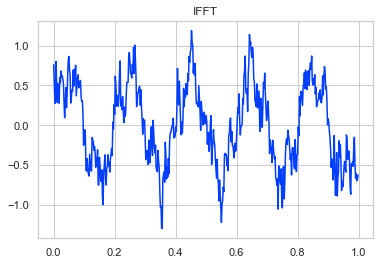

In [173]:
ift = fft.ifft(value)
plt.title('IFFT')
plt.plot(x,ift)